# Vehicle Detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

### Histogram of Oriented Gradients (HOG) and color histogram feature exploration

In [14]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
import glob
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.cross_validation import train_test_split
import time
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import pickle
from scipy.ndimage.measurements import label

%matplotlib inline

test_image='./test_images/test1.jpg'

Draw boxes method used to draw boxes in the image

In [15]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # make a copy of the image
    draw_img = np.copy(img)
    # draw each bounding box on your image copy using cv2.rectangle()
    for bbox in bboxes:
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # return the image copy with boxes drawn
    return draw_img

Color histogram function this function creates a histogram of color from a given image

In [16]:
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features

Quick visualization of the histograms created with the previous function

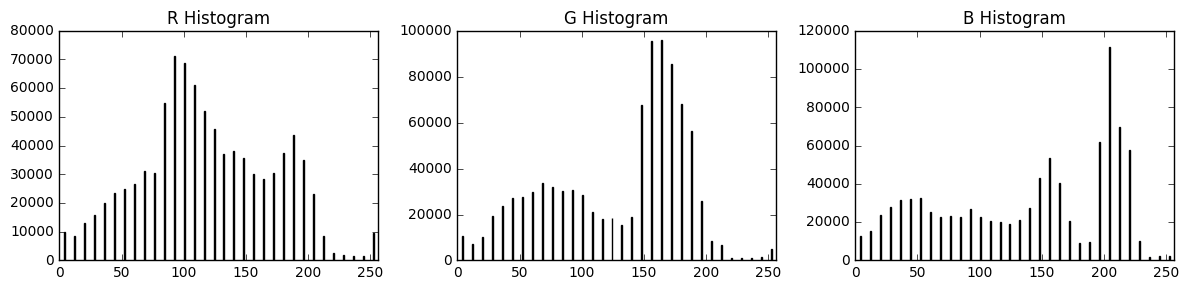

In [17]:
image = mpimg.imread(test_image)
rh, gh, bh, bincen, feature_vec = color_hist(image, nbins=32, bins_range=(0, 256))

# Plot a figure with all three bar charts
if rh is not None:
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.bar(bincen, rh[0])
    plt.xlim(0, 256)
    plt.title('R Histogram')
    plt.subplot(132)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    plt.title('G Histogram')
    plt.subplot(133)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    plt.title('B Histogram')
    fig.tight_layout()

# Color spaces exploration

Here I plot each channel from different color spaces, in the hope of visualizing which color space makes car features pop out from the rest of the picture, I think YUV and YCrCb colors spaces are promissing ones

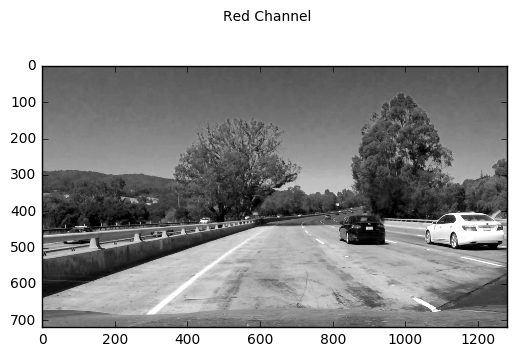

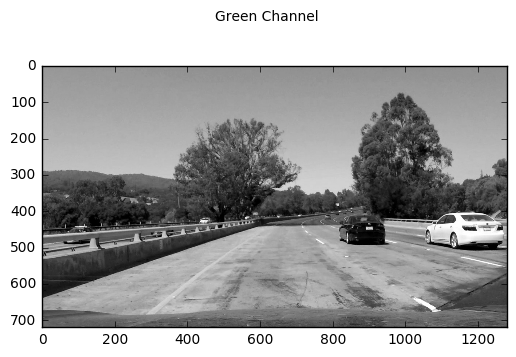

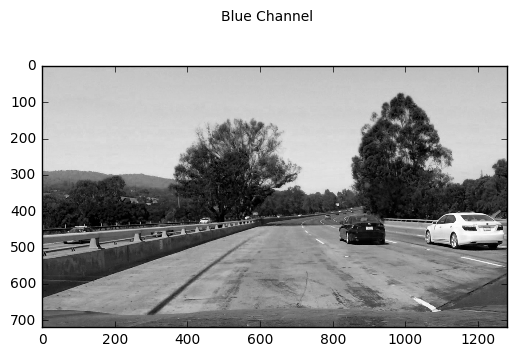

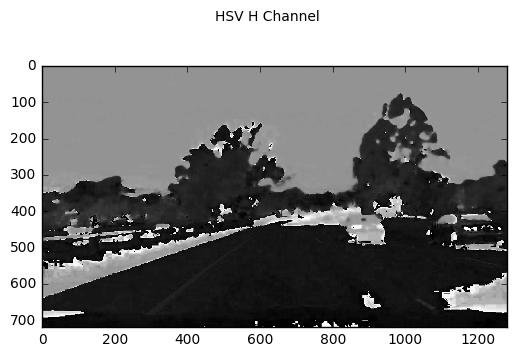

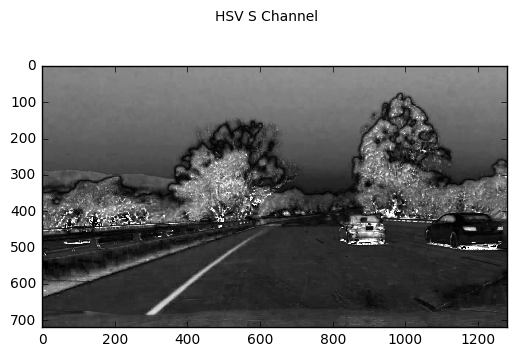

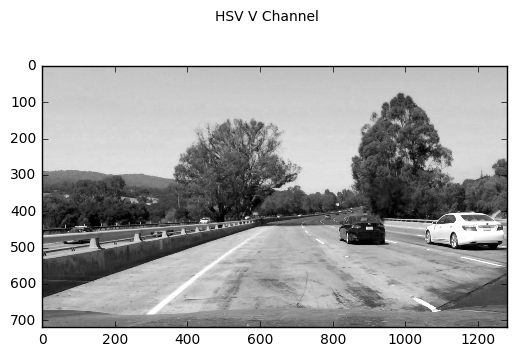

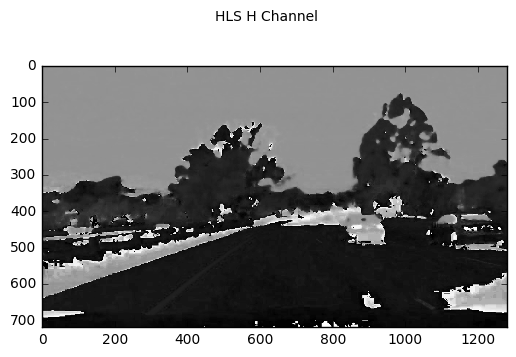

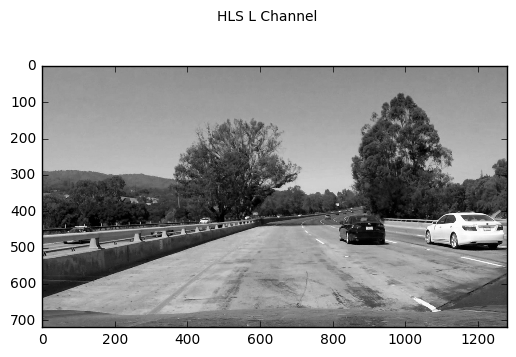

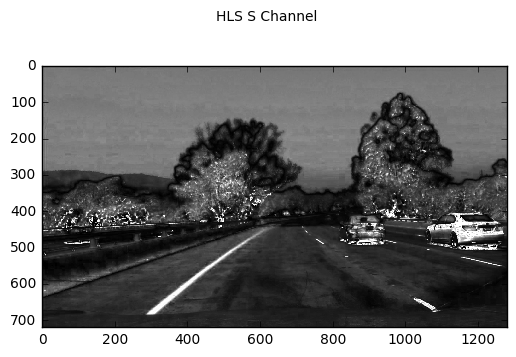

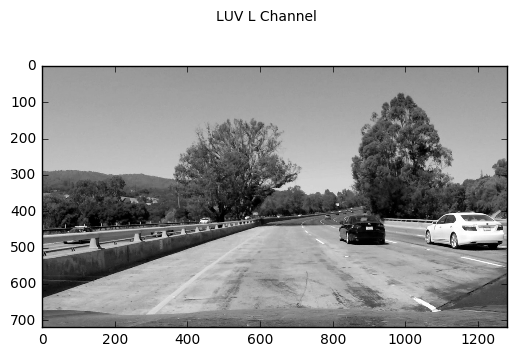

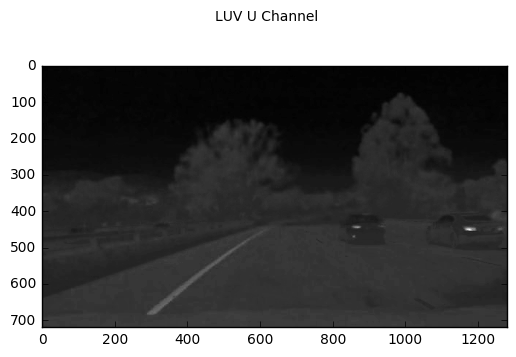

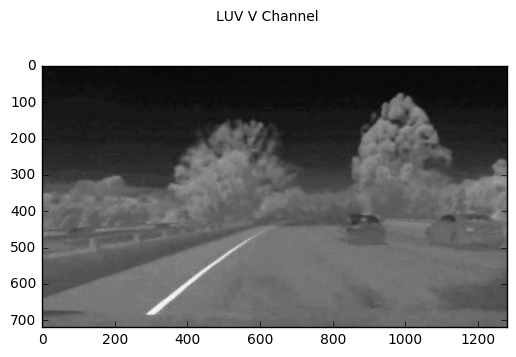

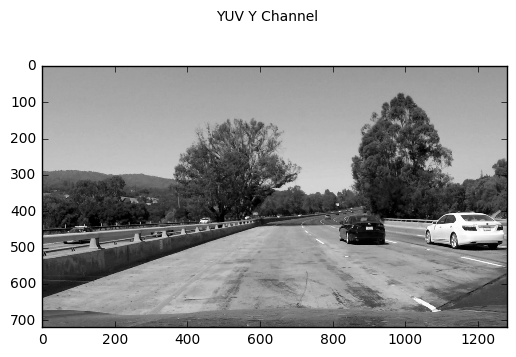

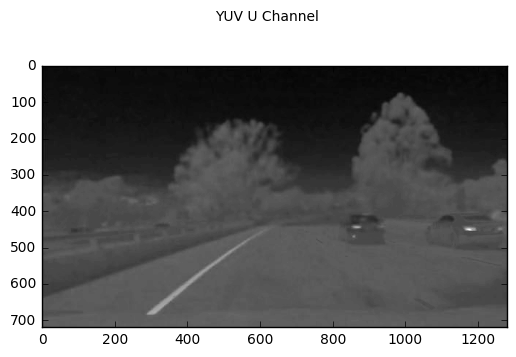

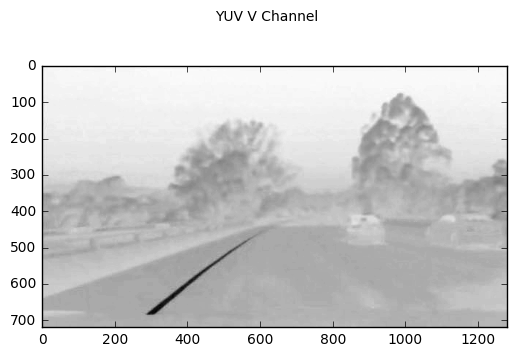

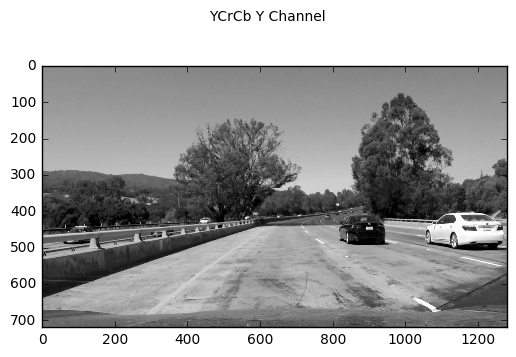

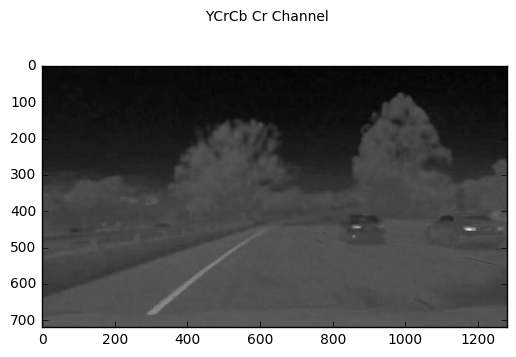

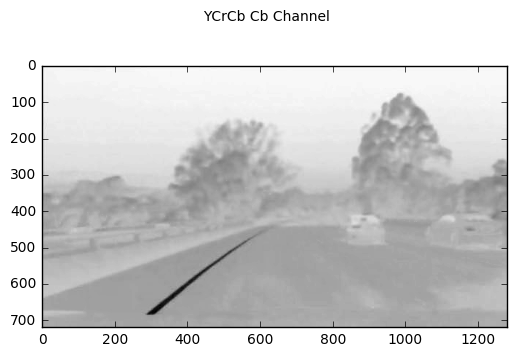

In [18]:

hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
luv = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
yuv = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
ycrcb = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)

A = image[:,:,0]
B = image[:,:,1]
C = image[:,:,2]
plt.figure()
plt.imshow(A, cmap='gray')
plt.suptitle("Red Channel")
plt.figure()
plt.imshow(B, cmap='gray')
plt.suptitle("Green Channel")
plt.figure()
plt.imshow(C, cmap='gray')
plt.suptitle("Blue Channel")

A = hsv[:,:,0]
B = hsv[:,:,1]
C = hsv[:,:,2]
plt.figure()
plt.imshow(A, cmap='gray')
plt.suptitle("HSV H Channel")
plt.figure()
plt.imshow(B, cmap='gray')
plt.suptitle("HSV S Channel")
plt.figure()
plt.imshow(C, cmap='gray')
plt.suptitle("HSV V Channel")

A = hls[:,:,0]
B = hls[:,:,1]
C = hls[:,:,2]
plt.figure()
plt.imshow(A, cmap='gray')
plt.suptitle("HLS H Channel")
plt.figure()
plt.imshow(B, cmap='gray')
plt.suptitle("HLS L Channel")
plt.figure()
plt.imshow(C, cmap='gray')
plt.suptitle("HLS S Channel")

A = luv[:,:,0]
B = luv[:,:,1]
C = luv[:,:,2]
plt.figure()
plt.imshow(A, cmap='gray')
plt.suptitle("LUV L Channel")
plt.figure()
plt.imshow(B, cmap='gray')
plt.suptitle("LUV U Channel")
plt.figure()
plt.imshow(C, cmap='gray')
plt.suptitle("LUV V Channel")

A = yuv[:,:,0]
B = yuv[:,:,1]
C = yuv[:,:,2]
plt.figure()
plt.imshow(A, cmap='gray')
plt.suptitle("YUV Y Channel")
plt.figure()
plt.imshow(B, cmap='gray')
plt.suptitle("YUV U Channel")
plt.figure()
plt.imshow(C, cmap='gray')
plt.suptitle("YUV V Channel")

A = ycrcb[:,:,0]
B = ycrcb[:,:,1]
C = ycrcb[:,:,2]
plt.figure()
plt.imshow(A, cmap='gray')
plt.suptitle("YCrCb Y Channel")
plt.figure()
plt.imshow(B, cmap='gray')
plt.suptitle("YCrCb Cr Channel")
plt.figure()
plt.imshow(C, cmap='gray')
plt.suptitle("YCrCb Cb Channel")

In [19]:
def plot3d(pixels, colors_rgb, axis_labels=list("RGB"), axis_limits=[(0, 255), (0, 255), (0, 255)]):
    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation

With the method above I explores how color are structured in 3d spaces

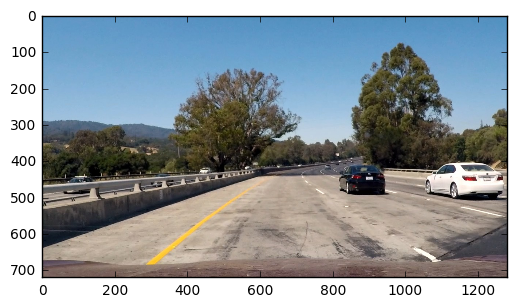

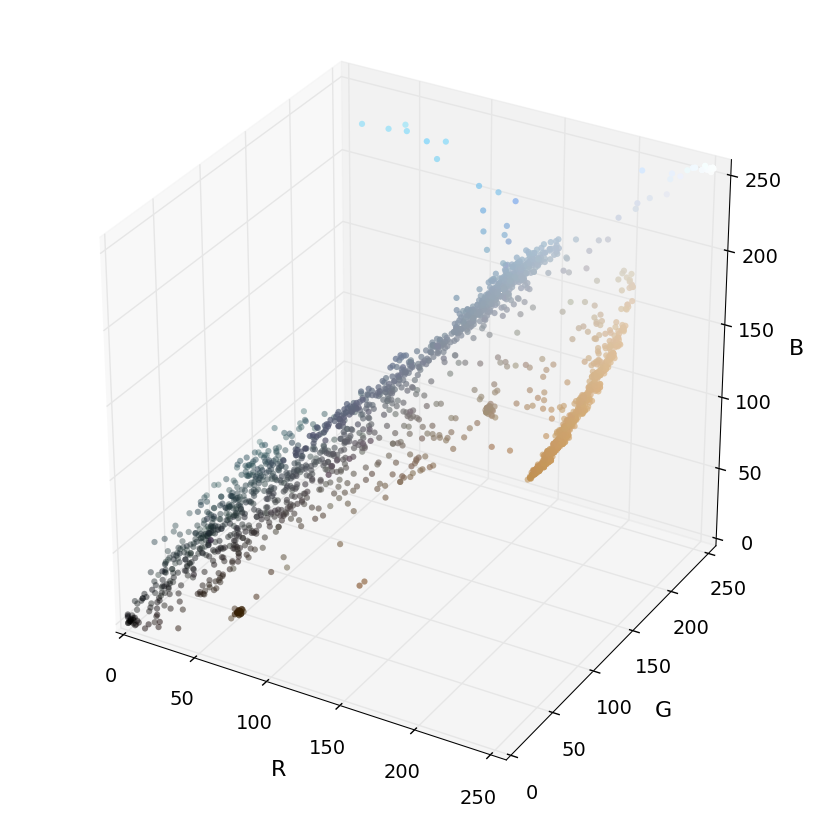

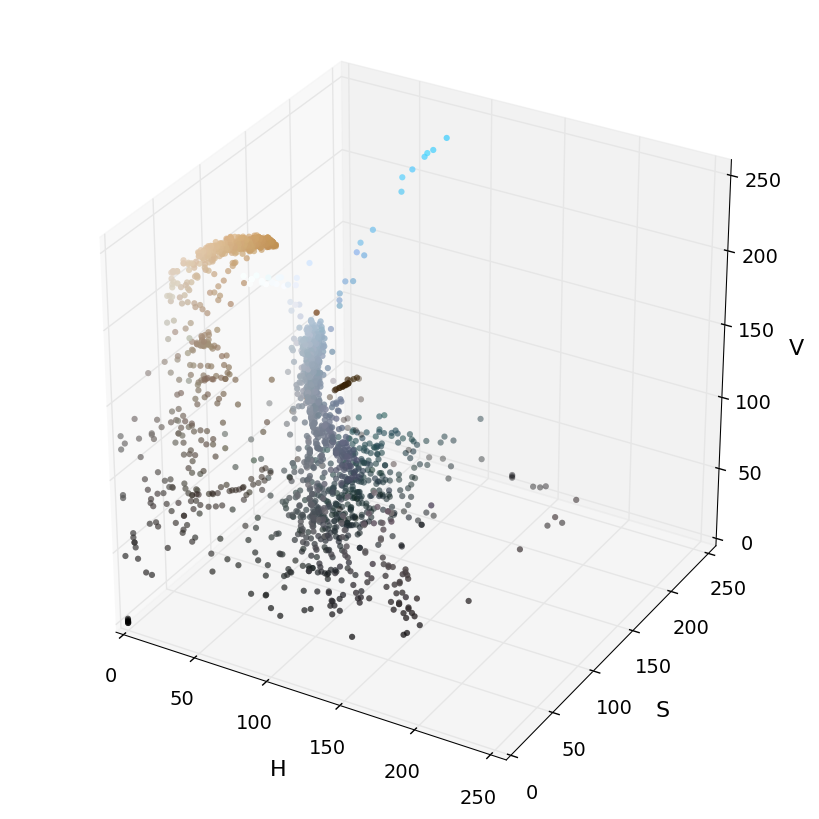

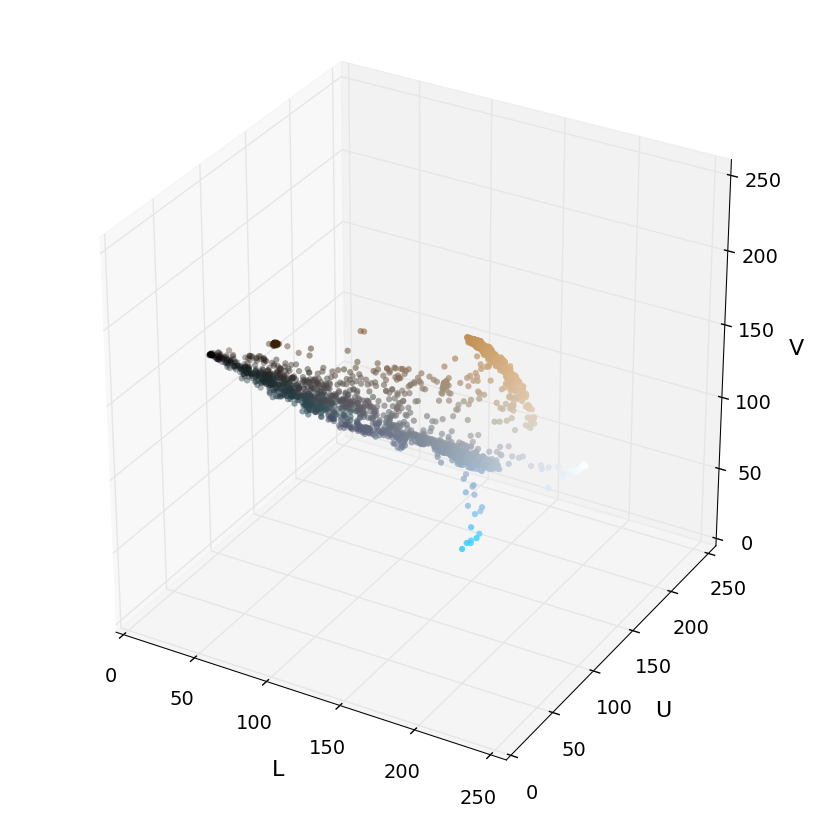

In [20]:
img = mpimg.imread(test_image)

plt.figure()
plt.imshow(img)

# Select a small fraction of pixels to plot by subsampling it
scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

# Convert subsampled image to desired color space(s)
img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
img_small_LUV = cv2.cvtColor(img_small, cv2.COLOR_BGR2LUV)



img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

# Plot and show
plot3d(img_small_RGB, img_small_rgb)
plt.show()

plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
plt.show()

plot3d(img_small_LUV, img_small_rgb, axis_labels=list("LUV"))
plt.show()

Here I redefine the bin_spatial method to account for color spaces

In [21]:
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    return features

Define a function to return some characteristics of the dataset

In [22]:
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict

Loading dataset for car classification

In [23]:
cars = glob.glob('./datasets/vehicles_smallset/*/*.jpeg')
notcars = glob.glob('./datasets/non-vehicles_smallset/*/*.jpeg')

print(len(cars))
print(len(notcars))

data_info = data_look(cars, notcars)

print('Your function returned a count of', data_info["n_cars"], ' cars and', data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')

0
0


IndexError: list index out of range

Here I define the extract hog features method.

In [ ]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

Now I load an image to test the hog extraction method and I verify how it will look like, I also tuned the varibles (orient, pix_per_cell, cell_per_block) to get what think would be a useful feature 

In [13]:
# Read in the image
image = mpimg.imread(cars[car_ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 8
pix_per_cell = 4
cell_per_block = 8
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

NameError: name 'car_ind' is not defined

Now I prepare two feature extraction methods just so I can test them separately 

In [24]:
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        rhist, ghist, bhist, bin_centers, hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))
    # Return list of feature vectors
    return features

def extract_hog_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Train a classifier

Here I previously loaded a dataset composed of a subset of images taken from the [GTI vehicle image database](http://www.gti.ssr.upm.es/data/Vehicle_database.html).

Below I extract and scale the features and I create two SVM classifiers one for each feature so I can compare their effectiviness

By far the classifier feed with hog features is the best and that's what I decide to use to classify cars.

In [ ]:
spatial = 32
histbin = 32

car_features = extract_features(cars, cspace='RGB', spatial_size=(spatial, spatial), hist_bins=histbin, hist_range=(0, 256))
notcar_features = extract_features(notcars, cspace='RGB', spatial_size=(spatial, spatial), hist_bins=histbin, hist_range=(0, 256))

if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_spatial_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_spatial_scaler.transform(X)
    car_ind = np.random.randint(0, len(cars))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(cars[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
else: 
    print('Your function only returns empty feature vectors...')

In [ ]:
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using spatial binning of:',spatial,
    'and', histbin,'histogram bins')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc_spatial = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc_spatial.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc_spatial.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc_spatial.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

In [ ]:
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8
pix_per_cell = 4
cell_per_block = 8
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

t=time.time()
car_hog_features = extract_hog_features(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_hog_features = extract_hog_features(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
hog_X = np.vstack((car_hog_features, notcar_hog_features)).astype(np.float64)                        
# Fit a per-column scaler
X_hog_scaler = StandardScaler().fit(hog_X)
# Apply the scaler to X
scaled_hog_X = X_hog_scaler.transform(hog_X)

# Define the labels vector
y = np.hstack((np.ones(len(car_hog_features)), np.zeros(len(notcar_hog_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_hog_train, X_hog_test, y_hog_train, y_hog_test = train_test_split(
    scaled_hog_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_hog_train[0]))
# Use a linear SVC 
svc_hog = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc_hog.fit(X_hog_train, y_hog_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc_hog.score(X_hog_test, y_hog_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc_hog.predict(X_hog_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_hog_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Below I save all necessary params for my car classification pipeline

In [25]:
save_classifier = False
if save_classifier:
    classifier_data = { 
        "color_space": colorspace, 
        "orient": orient,
        "pix_per_cell": pix_per_cell,
        "cell_per_block": cell_per_block,
        "hog_channel": hog_channel,
        "classifier": svc_hog,
        "scaller": X_hog_scaler
    }
    pickle.dump(classifier_data, open( "classifier_data.p", "wb" ))

# Sliding window

Loading pickled classification data

In [26]:
classifier_data = pickle.load( open( "classifier_data.p", "rb" ) )
color_space = classifier_data["color_space"]
orient = classifier_data["orient"]
pix_per_cell = classifier_data["pix_per_cell"]
cell_per_block = classifier_data["cell_per_block"]
hog_channel = classifier_data["hog_channel"]
svc_hog = classifier_data["classifier"]
X_hog_scaler = classifier_data["scaller"]

In [27]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


Here I define the windows I will use on my classification pipeline, the ploted image shows how the covered area will look like

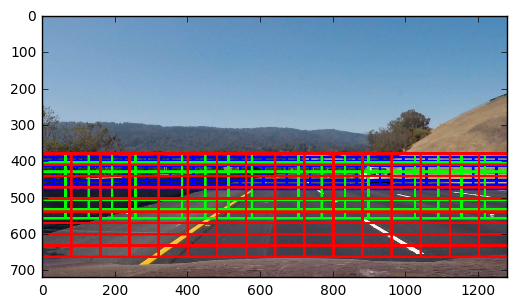

In [82]:
image = mpimg.imread(test_image)
initial_size = 64
windows1 = slide_window(image, x_start_stop=[None, None], y_start_stop=[390, 390+initial_size+initial_size*0.5], 
                    xy_window=(initial_size, initial_size), xy_overlap=(0.5, 0.8))
initial_size = 128
windows2 = slide_window(image, x_start_stop=[None, None], y_start_stop=[380, 380+initial_size+initial_size*0.5], 
                    xy_window=(initial_size, initial_size), xy_overlap=(0.5, 0.8))

initial_size = 160
windows3 = slide_window(image, x_start_stop=[None, None], y_start_stop=[380, 380+initial_size+initial_size*0.8], 
                    xy_window=(initial_size, initial_size), xy_overlap=(0.5, 0.8))

windows4 = slide_window(image, x_start_stop=[None, 960], y_start_stop=[400, 400+initial_size+initial_size*0.2], 
                    xy_window=(initial_size, initial_size), xy_overlap=(0.5, 0.8))

initial_size = 60
windows5 = slide_window(image, x_start_stop=[100, 1180], y_start_stop=[370, 370+initial_size+initial_size*0.5], 
                    xy_window=(initial_size, initial_size), xy_overlap=(0.5, 0.5))

initial_size += 16
windows6 = slide_window(image, x_start_stop=[64, None], y_start_stop=[380, 380+initial_size], 
                    xy_window=(initial_size, initial_size), xy_overlap=(0.5, 0.5))
                       
windows = []
windows.append(windows1)
windows.append(windows2)
windows.append(windows3)
#windows.append(windows4)
#windows.append(windows5)
#windows.append(windows6)

image = draw_boxes(image, windows1, color=(0, 0, 255), thick=6)
image = draw_boxes(image, windows2, color=(0, 255, 0), thick=6)
image = draw_boxes(image, windows3, color=(255, 0, 0), thick=6)
#image = draw_boxes(image, windows4, color=(0, 255, 255), thick=6)
#image = draw_boxes(image, windows5, color=(255, 255, 0), thick=6)
#image = draw_boxes(image, windows6, color=(255, 0, 255), thick=6)
plt.imshow(image)

In [83]:
def convert_color(image, cspace='RGB'):
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image) 
    
    return feature_image
        
def extract_hog_features(image, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # apply color conversion if other than 'RGB'
    feature_image = convert_color(image, cspace=cspace)

    # Call get_hog_features() with vis=False, feature_vec=True
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)        
    else:
        hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                    pix_per_cell, cell_per_block, vis=False, feature_vec=True)
    # Append the new feature vector to the features list
    features.append(hog_features)
    # Return list of feature vectors
    return features

In [84]:
# Define a function you will pass an image
def search_windows(img, windows, clf, scaler, color_space='RGB', orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows lists in the list
    index =0
    for window_list in windows:
        for window in window_list:
            #3) Extract the test window from original image
            test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
            #mpimg.imsave('./output_images/{}.jpg'.format(index),test_img)
            index += 1
            #4) Extract features for that window using extract_hog_features()
            features = extract_hog_features(test_img, cspace=color_space, orient=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                            hog_channel=hog_channel)
            #5) Scale extracted features to be fed to classifier
            test_features = scaler.transform(np.array(features).reshape(1, -1))
            #6) Predict using your classifier
            prediction = clf.predict(test_features)
            #7) If positive (prediction == 1) then save the window
            if prediction == 1:
                on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

I've defined this class to hold detectin from several frames

In [85]:
class Detections():
    def __init__(self, memmory_len=6):
        self.recent_detections = []
        self.memmory_len = memmory_len
    
    def add_detection(self, detections):

        while len(self.recent_detections) > self.memmory_len:
            self.recent_detections.pop(0)
            
        self.recent_detections.append(detections)
    
    

My final pipeline

    search on the windows and return positive windows
    
    store detections
    
    and over stored detections create heatmap 
    
    threshold heatmap and retrieve final labels

In [86]:
def process_image(image):
    global color_space
    global orient
    global pix_per_cell
    global cell_per_block
    global hog_channel
    global threshold
    global detection_tracker
    global plot_results
    
    boxes = search_windows(image, windows, svc_hog, X_hog_scaler, color_space=color_space, 
                   orient=orient, pix_per_cell=pix_per_cell, 
                   cell_per_block=cell_per_block, hog_channel=hog_channel)

    detection_tracker.add_detection(boxes)
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    for ds in detection_tracker.recent_detections:
        heat = add_heat(heat, ds)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, threshold)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(image, labels)
    
    if plot_results:
        fig = plt.figure()
        plt.subplot(121)
        plt.imshow(draw_img)
        plt.title('Car Positions')
        plt.subplot(122)
        plt.imshow(heatmap, cmap='hot')
        plt.title('Heat Map')
        fig.tight_layout()
    
    return draw_img

Here I experiment with several thresholds 

I tried to get something that would require more than one frame to give a positive detection

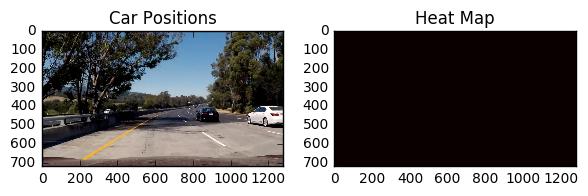

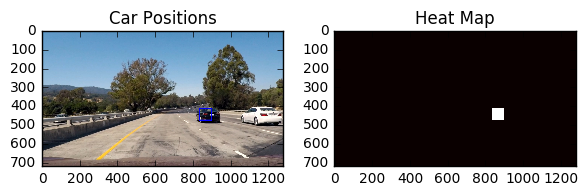

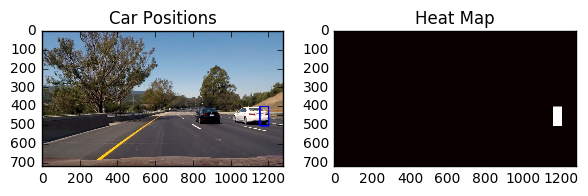

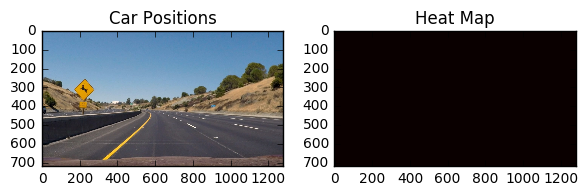

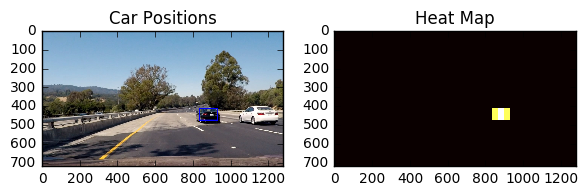

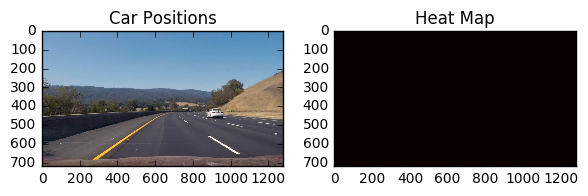

In [89]:
test_images = glob.glob('./test_images/*.jpg')
threshold = 4
plot_results = True
for test_image in test_images:
    detection_tracker = Detections()
    image = mpimg.imread(test_image)
    image = process_image(image)

Runing pipeline on test video

[MoviePy] >>>> Building video output_images/test_video.mp4
[MoviePy] Writing video output_images/test_video.mp4




  0%|          | 0/39 [00:00<?, ?it/s]

  3%|▎         | 1/39 [00:02<01:29,  2.35s/it]

  5%|▌         | 2/39 [00:04<01:27,  2.36s/it]

  8%|▊         | 3/39 [00:07<01:24,  2.35s/it]

 10%|█         | 4/39 [00:09<01:22,  2.35s/it]

 13%|█▎        | 5/39 [00:11<01:19,  2.35s/it]

 15%|█▌        | 6/39 [00:14<01:17,  2.34s/it]

 18%|█▊        | 7/39 [00:16<01:16,  2.39s/it]

 21%|██        | 8/39 [00:18<01:13,  2.38s/it]

 23%|██▎       | 9/39 [00:21<01:10,  2.36s/it]

 26%|██▌       | 10/39 [00:23<01:08,  2.35s/it]

 28%|██▊       | 11/39 [00:25<01:05,  2.35s/it]

 31%|███       | 12/39 [00:28<01:03,  2.34s/it]

 33%|███▎      | 13/39 [00:30<01:00,  2.35s/it]

 36%|███▌      | 14/39 [00:32<00:58,  2.35s/it]

 38%|███▊      | 15/39 [00:35<00:56,  2.35s/it]

 41%|████      | 16/39 [00:37<00:54,  2.39s/it]

 44%|████▎     | 17/39 [00:40<00:52,  2.37s/it]

 46%|████▌     | 18/39 [00:42<00:49,  2.36s/it]

 49%|████▊     | 19/39 [00:44<00:47,  2.36s/it]

 51%|█████▏    | 20/39 [00:47<00:44,

[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/test_video.mp4 

CPU times: user 1min 30s, sys: 10.7 s, total: 1min 41s
Wall time: 1min 30s


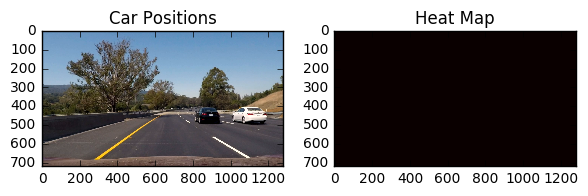

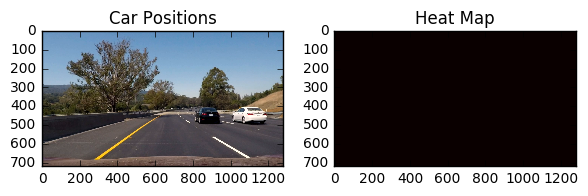

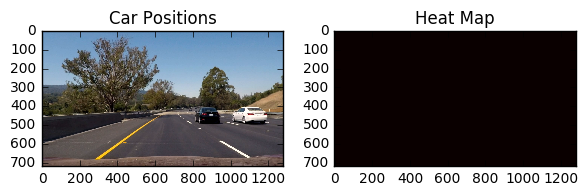

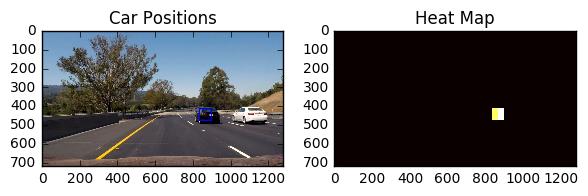

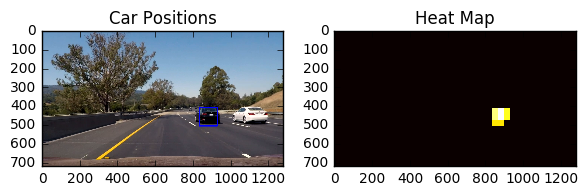

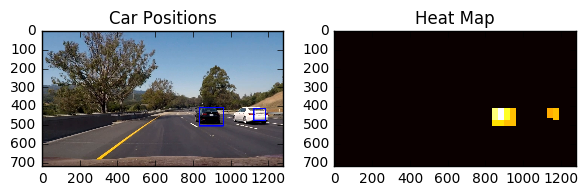

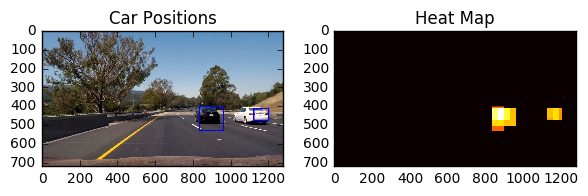

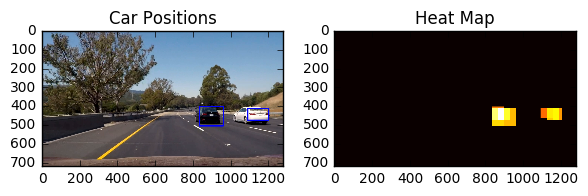

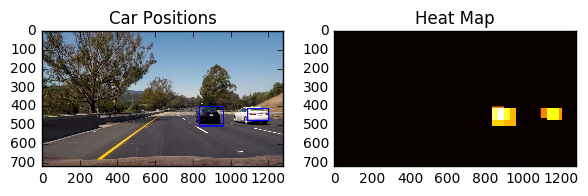

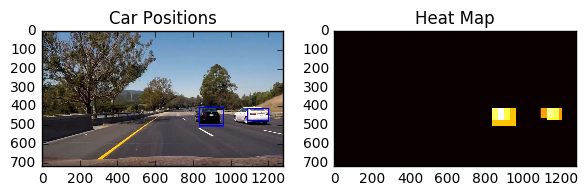

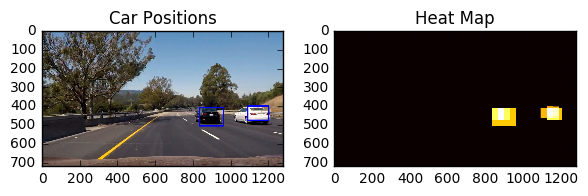

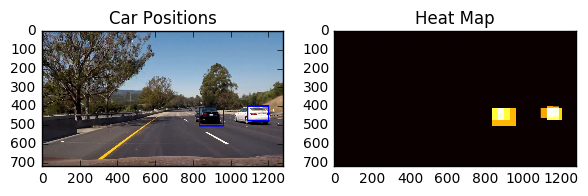

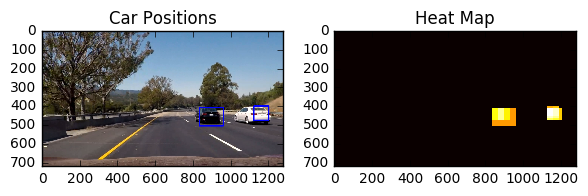

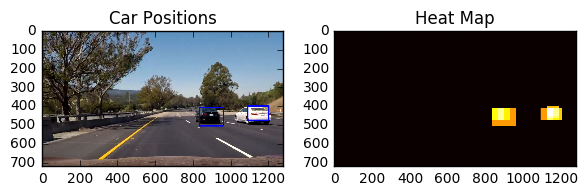

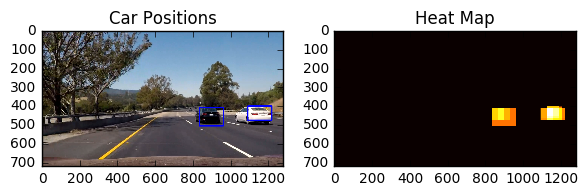

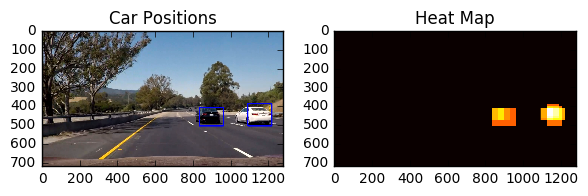

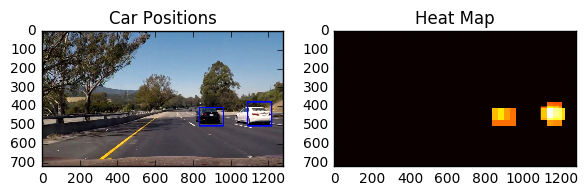

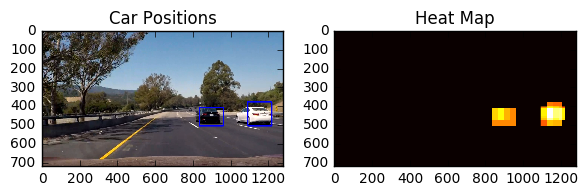

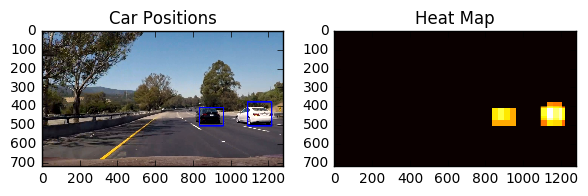

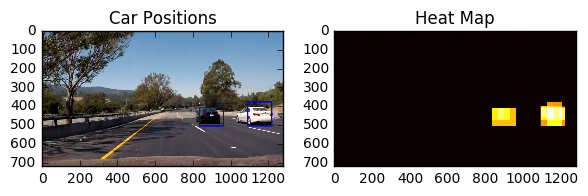

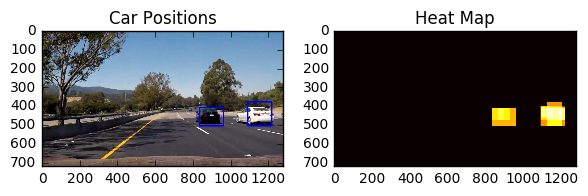

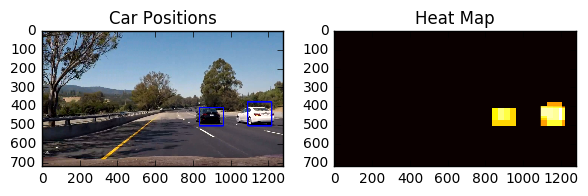

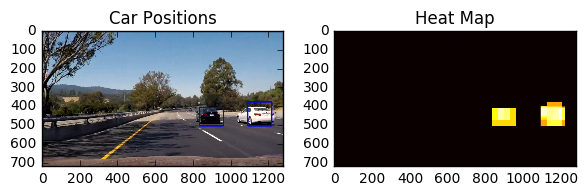

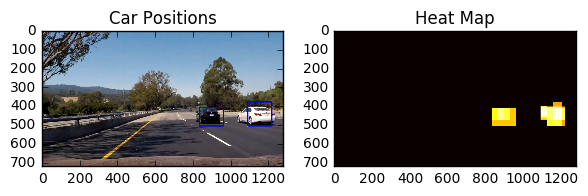

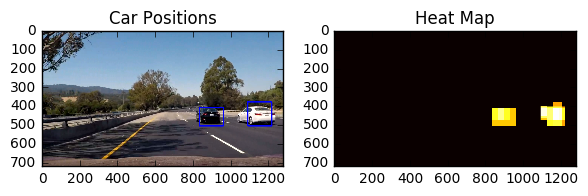

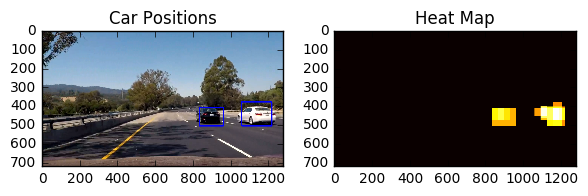

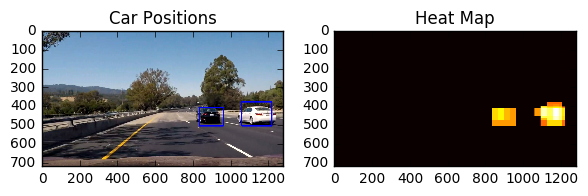

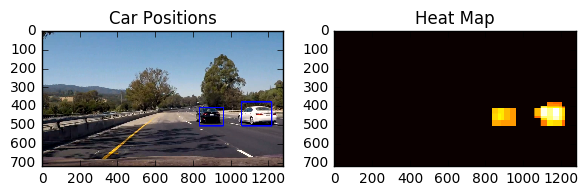

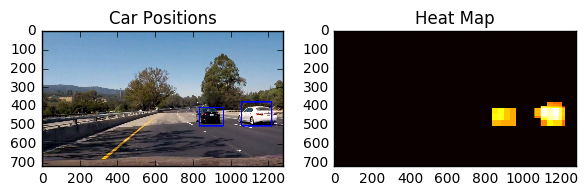

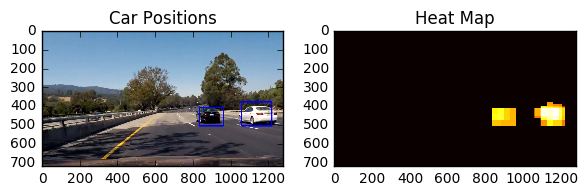

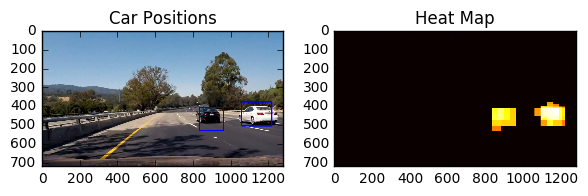

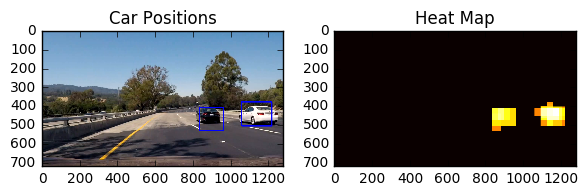

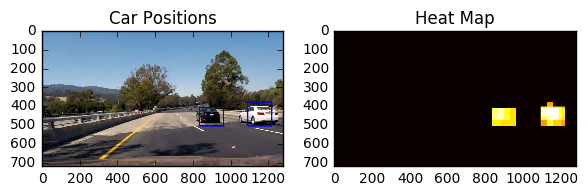

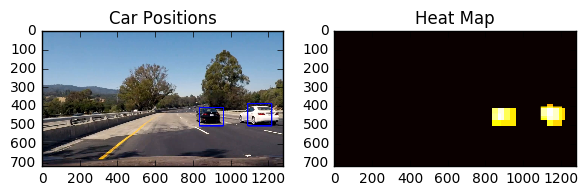

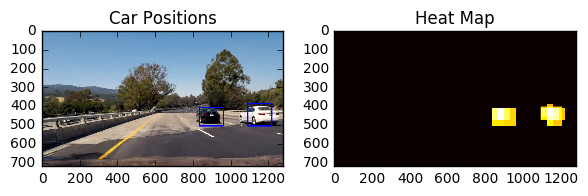

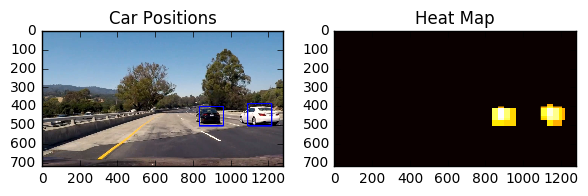

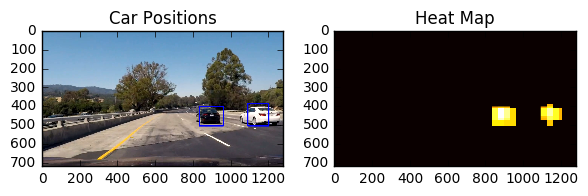

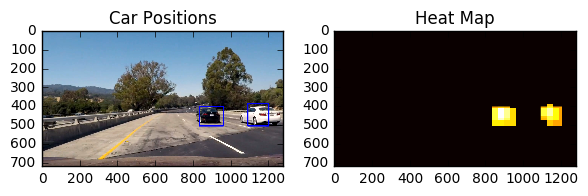

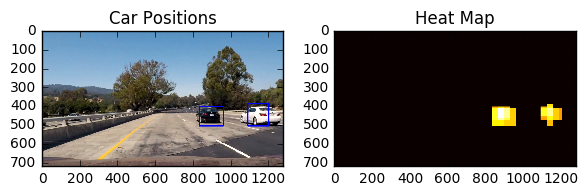

In [90]:
output = 'output_images/test_video.mp4'
clip1 = VideoFileClip("test_video.mp4")
plot_results = True
threshold = 21
detection_tracker = Detections()
processed_clip = clip1.fl_image(process_image)
%time processed_clip.write_videofile(output, audio=False)

In [96]:
HTML("<video width=\"960\" height=\"540\" controls><source src=\"output_images/test_video.mp4\"></video>")

Runing pipeline on project video

In [93]:
output = 'output_images/project_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
threshold = 21
plot_results = False
detection_tracker = Detections()
processed_clip = clip1.fl_image(process_image)
%time processed_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output_images/project_video.mp4
[MoviePy] Writing video output_images/project_video.mp4




  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 1/1261 [00:02<44:27,  2.12s/it]

  0%|          | 2/1261 [00:04<44:29,  2.12s/it]

  0%|          | 3/1261 [00:06<44:30,  2.12s/it]

  0%|          | 4/1261 [00:08<44:31,  2.12s/it]

  0%|          | 5/1261 [00:10<44:27,  2.12s/it]

  0%|          | 6/1261 [00:12<44:26,  2.12s/it]

  1%|          | 7/1261 [00:14<44:23,  2.12s/it]

  1%|          | 8/1261 [00:16<44:19,  2.12s/it]

  1%|          | 9/1261 [00:19<44:19,  2.12s/it]

  1%|          | 10/1261 [00:21<44:16,  2.12s/it]

  1%|          | 11/1261 [00:23<44:17,  2.13s/it]

  1%|          | 12/1261 [00:25<44:11,  2.12s/it]

  1%|          | 13/1261 [00:27<44:06,  2.12s/it]

  1%|          | 14/1261 [00:29<44:06,  2.12s/it]

  1%|          | 15/1261 [00:31<44:10,  2.13s/it]

  1%|▏         | 16/1261 [00:34<44:08,  2.13s/it]

  1%|▏         | 17/1261 [00:36<44:04,  2.13s/it]

  1%|▏         | 18/1261 [00:38<44:01,  2.13s/it]

  2%|▏         | 19/1261 [00:40<43:56,  2.12s/i

[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video.mp4 

CPU times: user 44min 43s, sys: 2.28 s, total: 44min 45s
Wall time: 44min 44s


In [95]:
HTML("<video width=\"960\" height=\"540\" controls><source src=\"output_images/project_video.mp4\"></video>")

# Dicussions

In general this project was pretty straight forward. I would like again to have had more time to do it with more care. But I am happy with the results

I would like to fine tune the windows, and use the subsample hog extraction, and that's something I will do with more time.

Also would like to experiment with a neural network as the classifier, or maybe mix of different classifers, I think that having a softmax, that gives off a percentage of sureness, would be good to provide better heat maps.

